In [3]:
# import libraries
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.models import Model
from matplotlib import pyplot
import sys

In [4]:
train_path = 'C:/Users/linascim/Downloads/dataset_dogs_vs_cats/train/'
test_path = 'C:/Users/linascim/Downloads/dataset_dogs_vs_cats/test/'

473176280/473176280 [==============================] - 22s 0us/step
Found 18612 images belonging to 2 classes.
Found 6279 images belonging to 2 classes.
Epoch 1/10
291/291 [==============================] - 6332s 22s/step - loss: 0.0574 - accuracy: 0.9796 - val_loss: 0.0430 - val_accuracy: 0.9863
Epoch 2/10
291/291 [==============================] - 5482s 19s/step - loss: 0.0352 - accuracy: 0.9879 - val_loss: 0.0405 - val_accuracy: 0.9861
Epoch 3/10
291/291 [==============================] - 5172s 18s/step - loss: 0.0261 - accuracy: 0.9907 - val_loss: 0.0425 - val_accuracy: 0.9850
Epoch 4/10
291/291 [==============================] - 5200s 18s/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0387 - val_accuracy: 0.9869
Epoch 5/10
291/291 [==============================] - 5245s 18s/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0391 - val_accuracy: 0.9868
Epoch 6/10
291/291 [==============================] - 5849s 20s/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 0.0441 

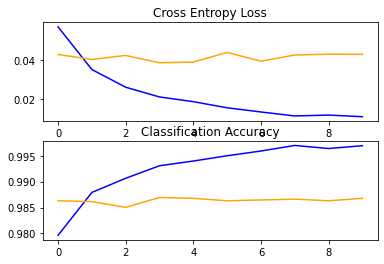

In [5]:
# EfficientNetV2L model used for transfer learning on the dogs and cats dataset

# define cnn model
def define_model():
	# load model
	model = EfficientNetV2L(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model


# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.show()
	pyplot.close()


# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory(train_path,
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory(test_path,
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()